In [100]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/data/src/xflsvg/src')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from xflsvg import *
import os

path = '/data/samples/MLP509_091'
# path = '/data/samples/422/MLP422_100'
xfl = XflReader(path)
timeline = xfl.get_timeline()

output_path = '/data/samples/out'
!rm -r $output_path
os.makedirs('/data/samples/out', exist_ok=True)

for i, frame in enumerate(timeline):
    with SvgRenderer() as renderer:
        frame.render()
    svg = renderer.compile(xfl.width, xfl.height)
    with open(f'{output_path}/frame%03d.svg' % i, 'w') as outfile:
        svg.write(outfile, encoding='unicode')

ModuleNotFoundError: No module named 'xflsvg'

In [ ]:
import numpy
start = numpy.matrix([[0.7044677734375, 0], [0, 0.105255126953125]])
end = numpy.matrix([[2.43000793457031, 1.40292358398438], [1.130126953125, 1.13653564453125]])

In [ ]:
import numpy
import math

def polar_decomposition(matrix):
    u, s, vh = numpy.linalg.svd(matrix)
    pu = u @ vh # rotation matrix
    angle = math.atan2(pu[1,0], pu[0,0])
    
    pp = vh.T @ numpy.diag(s) @ vh # scaling matrix
#     scale = numpy.diag(pp)
#     skew = pp / scale
    return pp, angle # scale, angle, skew

def recompose_polar(scale, angle, skew):
    pp = numpy.multiply(skew, scale)
    pu = numpy.array([[math.cos(angle), -math.sin(angle)], [math.sin(angle), math.cos(angle)]])
    return pu @ pp

# scale, angle, skew = polar_decomposition(end)
# recon = recompose_polar(scale, angle, skew)
# print(recon)
# print(end)

In [ ]:
start_props = polar_decomposition(start)
end_props = polar_decomposition(end)

steps = 20

diff_det = -(start_props[0] - end_props[0]) / (steps - 1)
diff_angle = 0 # -(start_props[1] - end_props[1]) / (steps-1)
diff_skew = 0 # -(start_props[2] - end_props[2]) / (steps-1)

print(diff_det, diff_angle, diff_skew)

current_det, current_angle, current_skew = start_props[:]

for i in range(steps-1):
    new_det = start_props[0] + i * diff_det
    new_angle = start_props[1] + i * diff_angle
    new_skew = start_props[2] + i * diff_skew
    print(recompose_polar(new_det, new_angle, new_skew))




interp: [0.0, 0.0, 0.0, array([0.70446777, 0.10525513])]
interp: [-0.011816764760881853, 0.0014950685170410003, 0.0026669062647750592, array([0.6987153 , 0.11457182])]
interp: [-0.023633529521763705, 0.0029901370340820006, 0.0053338125295501184, array([0.69296283, 0.12388851])]
interp: [-0.03545029428264556, 0.004485205551123001, 0.008000718794325177, array([0.68721035, 0.1332052 ])]
interp: [-0.04726705904352741, 0.005980274068164001, 0.010667625059100237, array([0.68145788, 0.14252189])]
interp: [-0.05908382380440926, 0.007475342585205001, 0.013334531323875295, array([0.6757054 , 0.15183859])]
interp: [-0.07090058856529112, 0.008970411102246003, 0.016001437588650354, array([0.66995293, 0.16115528])]
interp: [-0.08271735332617297, 0.010465479619287002, 0.018668343853425414, array([0.66420046, 0.17047197])]
interp: [-0.09453411808705482, 0.011960548136328002, 0.021335250118200474, array([0.65844798, 0.17978866])]
interp: [-0.10635088284793669, 0.013455616653369003, 0.024002156382975533

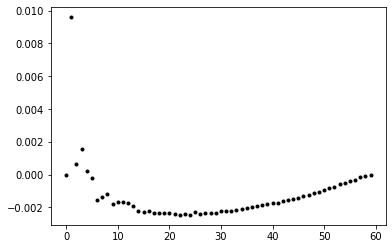

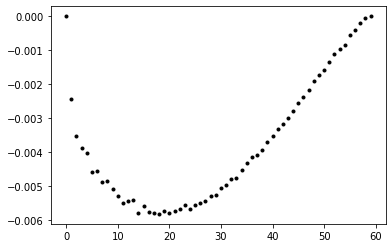

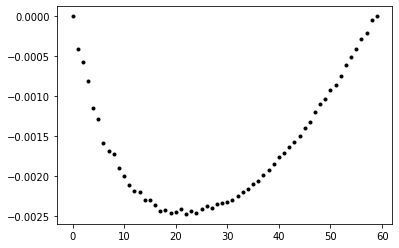

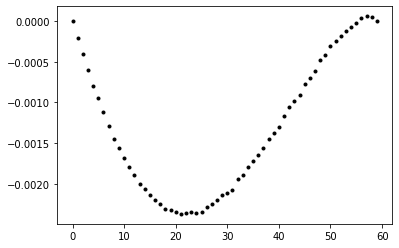

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [90]:
from bs4 import BeautifulSoup
from glob import glob
from matplotlib import pyplot as plt
import numpy
import math

xflPath = r'C:\Users\synthbot\animate-tools\output\Untitled-1'
svgPath = r'C:\Users\synthbot\Downloads\tweens'

def read_matrices(path):
    for f in sorted(glob(path)):
        with open(f) as inp:
            soup = BeautifulSoup(inp.read(), 'html5lib')
            for g in soup.svg.findChildren('g', recursive=False):
                if g.has_attr('id'):
                    continue
                if g['transform']:
                    data = g['transform']
                    left = data.find('(') + 1
                    right = data.find(')')
                    elements = [float(x.strip()) for x in data[left:right].split(',')]
                    transform = numpy.array(elements[:4]).reshape((2,2))
                    translate = numpy.array(elements[4:])
                    yield transform.T, translate
                    break

mats = list(read_matrices(f'{svgPath}/*'))
tf = numpy.array([x[0] for x in mats])
tx = numpy.array([x[1] for x in mats])

def plot_diffs(m, f, diff=lambda x,y: numpy.linalg.inv(x) @ y):
    plt.figure()
    pairs = zip(range(len(m)-1), m[:-1], m[1:])
    for i, pre, post in pairs:
        delta = diff(m[0], post)
        y = f(delta)
        plt.plot(i, y, 'k.')
    plt.show()
    plt.close()
        
def plot(m, f=lambda x: x):
    plt.figure()
    for i, x in enumerate(m):
        y = f(x)
        plt.plot(i, y, 'k.')
    plt.show()
    plt.close()
    
    
def polar_decomposition(matrix):
    u, s, vh = numpy.linalg.svd(matrix)
    pu = u @ vh # rotation matrix
    pp = vh.T @ numpy.diag(s) @ vh # scaling matrix
    return pu, pp

    
def polar_angle(m):
    pu, pp = polar_decomposition(m)
    angle = math.atan2(pu[1,0], pu[0,0]) * numpy.linalg.det(pu)
    return angle

def polar_scale_x(m):
    pu, pp = polar_decomposition(m)
    return numpy.linalg.svd(pp)[1][0]

def polar_scale_y(m):
    pu, pp = polar_decomposition(m)
    return numpy.linalg.svd(pp)[1][1]


def polar_skew_angle_u(m):
    pu, pp = polar_decomposition(m)
    u, s, vh = numpy.linalg.svd(pp)
    
    return math.atan2(u[1,0], u[0,0])

def polar_skew_angle_vh(m):
    pu, pp = polar_decomposition(m)
    u, s, vh = numpy.linalg.svd(pp)
    
    return math.atan2(vh[1,0], vh[0,0])

def logabs(m):
    return numpy.log(numpy.abs(m))

def exp(m):
    return numpy.exp(m)

def uhlman_decomposition(a):
    m = a.shape[0]
    n = a.shape[1]
    jm = numpy.ones((m, m)) / m
    jn = numpy.ones((n, n)) / n
    l = logabs(a)
    
    s = exp(jm @ l @ jn - l @ jn - jm @ l)
    y = s[0]
    x = numpy.array([1, s[1,0] / y[0]])
    
    dlu = numpy.diag(x)
    dru = numpy.diag(y)
    d = numpy.linalg.inv(dlu)
    e = numpy.linalg.inv(dru)
    
    usvt = dlu @ a @ dru
    u, s, vt = numpy.linalg.svd(usvt)
    return d, u, s, vt, e

def convert_angle(a):
    a = a % (math.pi * 2)
    if a > math.pi:
        a -= 2 * math.pi
    return a
    

def decomp_polar(a):
    pu, pp = polar_decomposition(a)
    
    post_angle = math.atan2(pu[1,0], pu[0,0])
    post_angle = convert_angle(post_angle)

    vals, vects = numpy.linalg.eig(pp)
    pre_angle = math.atan2(vects[1,0], vects[0,0])
    pre_angle = convert_angle(pre_angle)
    
    return post_angle, numpy.diag(vals), pre_angle


def recomp_polar(d):
    del_post, del_scales, del_pre = d
    
    rec_pu = numpy.array([
        [numpy.cos(del_post), -numpy.sin(del_post)],
        [numpy.sin(del_post), numpy.cos(del_post)]])
    
    rec_vects = numpy.array([
        [numpy.cos(del_pre), -numpy.sin(del_pre)],
        [numpy.sin(del_pre), numpy.cos(del_pre)]])
    

    rec_pp = rec_vects @ del_scales @ rec_vects.T
    return rec_pu @ rec_pp

def decomp_skew(a):
#     pu, pp = polar_decomposition(a)
#     rotation = math.atan2(pu[1,0], pu[0,0])
    
    d = skew_angles(a)
    return d

def recomp_skew(d):
#     return skew_matrix(*d)
    print('interp:', d)
    return skew_matrix(*d)
    

def decomp_svd(a):
    u, s, v = numpy.linalg.svd(a)
    post_angle = math.atan2(u[1,0], u[0,0])
    pre_angle = math.atan2(v[1,0], v[0,0])
    
    return post_angle, numpy.sqrt(numpy.diag(s)), pre_angle

def recomp_svd(d):
    del_post, del_scales, del_pre = d
    
    rec_u = numpy.array([
        [numpy.cos(del_post), -numpy.sin(del_post)],
        [numpy.sin(del_post), numpy.cos(del_post)]])

    rec_v = numpy.array([
        [numpy.cos(del_pre), -numpy.sin(del_pre)],
        [numpy.sin(del_pre), numpy.cos(del_pre)]])

    return rec_u @ del_scales**2 @ rec_v.T

def decomp_elem(a):
    return a

def recomp_elem(a):
    return a


def sim(f1, fn, n):
#     decomp, recomp = decomp_polar, recomp_polar
    decomp, recomp = decomp_skew, recomp_skew
#     decomp, recomp = decomp_svd, recomp_svd
#     decomp, recomp = decomp_elem, recomp_elem
    
    f1_decomp = decomp(f1)
    fn_decomp = decomp(fn)
    
    def interpolate(i):
        frac = i / (n - 1)
        return [
            frac*fn_d + (1-frac)*f1_d for fn_d, f1_d in zip(fn_decomp, f1_decomp)
        ]
    
    for i in range(n):
        yield recomp(interpolate(i))
    
    
def check_decomp(i, a, b):
    print(a)
    print(b)
    
    error = (b-a) / (a + 1e-10)
    print('===')
    
    plt.figure(1)    
    plt.plot(i, error[0,0], 'k.')
    
    plt.figure(2)
    plt.plot(i, error[0,1], 'k.')
    
    plt.figure(3)
    plt.plot(i, error[1,0], 'k.')
    
    plt.figure(4)
    plt.plot(i, error[1,1], 'k.')
    

def compare(m, fn):
    recon = list(fn(m[0], m[-1], len(m)))
    
    for i, x, s in zip(range(len(m)), m, recon):
        check_decomp(i, x, s)
#         pre, scales, post = decomp(mul_err)
#   
    for i in range(1, 5):
        plt.figure(i)
        plt.show()
        plt.close()

    
def skew_angles(a):
    pu, pp = polar_decomposition(a)
    rotation = math.atan2(pu[1,0], pu[0,0])
    
    scale = numpy.array([pp[0,0] - pp[1,0]*pp[0,1]/pp[1,1], pp[1,1]])
    skew = pp @ numpy.diag(1/scale)
    skew_x = math.atan(skew[0,1])
    skew_y = math.atan(skew[1,0])
    return rotation, skew_x, skew_y, scale
 
def skew_matrix(rotation, skew_x, skew_y, scale):
    pu = numpy.array([
        [math.cos(rotation), -math.sin(rotation)],
        [math.sin(rotation), math.cos(rotation)]
    ])
    
    tanx = math.tan(skew_x)
    tany = math.tan(skew_y)
    rec_skew = numpy.array([
        [1 + tanx*tany, tanx],
        [tany, 1]
    ])

    return pu @ rec_skew @ numpy.diag(scale)


# plot_diffs(tf, polar_uhlman)
compare(tf, sim)

# plot(tf, lambda x: polar_angle(x))
# plot(tf, lambda x: polar_scale_x(x))
# plot(tf, lambda x: polar_scale_y(x))

In [109]:


import json

mats = list(read_matrices(f'{svgPath}/*'))
json.dumps([numpy.ndarray.tolist(x[0]) for x in mats])

'[[[0.7044677734375, 0.0], [0.0, 0.105255126953125]], [[0.7063140869140625, -0.0041656494140625], [-0.006256103515625, 0.130645751953125]], [[0.708160400390625, -0.0099639892578125], [-0.0125579833984375, 0.1558685302734375]], [[0.7099151611328125, -0.017364501953125], [-0.018890380859375, 0.1808013916015625]], [[0.711639404296875, -0.0263824462890625], [-0.0252532958984375, 0.205413818359375]], [[0.7133026123046875, -0.0369873046875], [-0.0316619873046875, 0.2295989990234375]], [[0.7148895263671875, -0.049163818359375], [-0.0380859375, 0.2533111572265625]], [[0.7164306640625, -0.0628509521484375], [-0.0445556640625, 0.27642822265625]], [[0.7179107666015625, -0.078094482421875], [-0.051025390625, 0.298919677734375]], [[0.719329833984375, -0.0948333740234375], [-0.05755615234375, 0.3206939697265625]], [[0.7207183837890625, -0.1130218505859375], [-0.064117431640625, 0.3416900634765625]], [[0.722015380859375, -0.132659912109375], [-0.0706939697265625, 0.36181640625]], [[0.7232513427734375